# Diagnostic Sweep Evaluation: Multi-Critic with Fixes

**Purpose:** Evaluate multi-critic unlearning with gradient fixes

**Date:** November 8, 2025

**Configurations:**
1. Lambda=10, balance=none
2. Lambda=10, balance=ema_ratio
3. Lambda=5, balance=none
4. Lambda=5, balance=ema_ratio

**All configs use:**
- Feature-space MMD (gamma=0.1)
- Matched unseen loader
- Fixed gradient tracking
- 30 epochs

**Comparison:**
- Baseline: AUC = 0.951
- Retrain floor: AUC = 0.864
- Target band: [0.834, 0.894]
- Previous multi-critic (lambda=1, no fixes): AUC = 0.995 (FAILED)

In [1]:
import sys
sys.path.append('src')

import json
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

from vae import VAE
from attacker import MLPAttacker, extract_vae_features, build_attack_features
from utils import set_global_seed

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

In [2]:
set_global_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Configuration

In [3]:
DATA_PATH = "data/adata_processed.h5ad"
SPLIT_PATH = "outputs/p1/split_structured.json"

CONFIGS = [
    {
        'name': 'Lambda=10, No Balance',
        'short_name': 'lambda10_nobalance',
        'checkpoint': 'outputs/p2/sweep_lambda10_nobalance/best_model.pt',
        'lambda': 10,
        'balance': 'none'
    },
    {
        'name': 'Lambda=10, EMA Balance',
        'short_name': 'lambda10_ema',
        'checkpoint': 'outputs/p2/sweep_lambda10_ema/best_model.pt',
        'lambda': 10,
        'balance': 'ema_ratio'
    },
    {
        'name': 'Lambda=5, No Balance',
        'short_name': 'lambda5_nobalance',
        'checkpoint': 'outputs/p2/sweep_lambda5_nobalance/best_model.pt',
        'lambda': 5,
        'balance': 'none'
    },
    {
        'name': 'Lambda=5, EMA Balance',
        'short_name': 'lambda5_ema',
        'checkpoint': 'outputs/p2/sweep_lambda5_ema/best_model.pt',
        'lambda': 5,
        'balance': 'ema_ratio'
    }
]

print("Evaluating configurations:")
for i, cfg in enumerate(CONFIGS, 1):
    print(f"{i}. {cfg['name']}")
    print(f"   Checkpoint: {cfg['checkpoint']}")

Evaluating configurations:
1. Lambda=10, No Balance
   Checkpoint: outputs/p2/sweep_lambda10_nobalance/best_model.pt
2. Lambda=10, EMA Balance
   Checkpoint: outputs/p2/sweep_lambda10_ema/best_model.pt
3. Lambda=5, No Balance
   Checkpoint: outputs/p2/sweep_lambda5_nobalance/best_model.pt
4. Lambda=5, EMA Balance
   Checkpoint: outputs/p2/sweep_lambda5_ema/best_model.pt


## 2. Load Data and Splits

In [4]:
adata = sc.read_h5ad(DATA_PATH)
print(f"Data shape: {adata.shape}")

with open(SPLIT_PATH, 'r') as f:
    splits = json.load(f)

forget_indices = np.array(splits['forget_indices'])
retain_indices = np.array(splits['retain_indices'])
unseen_indices = np.array(splits['unseen_indices'])

print(f"\nSplit sizes:")
print(f"  Forget: {len(forget_indices)}")
print(f"  Retain: {len(retain_indices)}")
print(f"  Unseen: {len(unseen_indices)}")

Data shape: (33088, 2000)

Split sizes:
  Forget: 30
  Retain: 28094
  Unseen: 4964


## 3. Helper Functions

In [5]:
def create_feature_dataset(vae, adata, indices, device, batch_size=256):
    """Extract VAE features for attacker training."""
    vae.eval()
    all_features = []
    
    for i in range(0, len(indices), batch_size):
        batch_idx = indices[i:i+batch_size]
        X = torch.FloatTensor(
            adata.X[batch_idx].toarray() if hasattr(adata.X[batch_idx], 'toarray') 
            else adata.X[batch_idx]
        ).to(device)
        library_size = torch.FloatTensor(X.sum(dim=1, keepdim=True)).to(device)
        
        with torch.no_grad():
            vae_feats = extract_vae_features(vae, X, library_size, device)
            attack_feats = build_attack_features(vae_feats)
            all_features.append(attack_feats.cpu())
    
    return torch.cat(all_features, dim=0)

def train_attacker(pos_features, neg_features, input_dim, device, epochs=100, lr=0.001, verbose=True):
    """Train attacker to distinguish positive (1) from negative (0)."""
    # Create dataset
    pos_labels = torch.ones(len(pos_features), 1)
    neg_labels = torch.zeros(len(neg_features), 1)
    
    X = torch.cat([pos_features, neg_features], dim=0)
    y = torch.cat([pos_labels, neg_labels], dim=0)
    
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    
    # Initialize attacker
    attacker = MLPAttacker(
        input_dim=input_dim,
        hidden_dims=[256, 256],
        dropout=0.3,
        use_spectral_norm=True
    ).to(device)
    
    optimizer = optim.Adam(attacker.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    # Train
    attacker.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            logits = attacker(batch_X)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if verbose and (epoch + 1) % 20 == 0:
            print(f"  Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(loader):.4f}")
    
    attacker.eval()
    return attacker

def evaluate_binary(attacker, pos_features, neg_features, device):
    """Evaluate attacker on binary classification task."""
    attacker.eval()
    
    with torch.no_grad():
        pos_logits = attacker(pos_features.to(device)).cpu().numpy()
        neg_logits = attacker(neg_features.to(device)).cpu().numpy()
    
    pos_scores = torch.sigmoid(torch.FloatTensor(pos_logits)).numpy()
    neg_scores = torch.sigmoid(torch.FloatTensor(neg_logits)).numpy()
    
    y_true = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    y_score = np.concatenate([pos_scores, neg_scores])
    
    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    
    return auc, fpr, tpr

def tpr_at_fpr(fpr, tpr, target_fpr):
    """Get TPR at target FPR."""
    idx = np.where(fpr <= target_fpr)[0]
    if len(idx) == 0:
        return 0.0
    return tpr[idx[-1]]

print("Helper functions loaded.")

Helper functions loaded.


## 4. Evaluate All Configurations

In [6]:
results = []

for i, cfg in enumerate(CONFIGS, 1):
    print(f"\n{'='*70}")
    print(f"Config {i}/4: {cfg['name']}")
    print(f"{'='*70}")
    
    # Load VAE
    print(f"\nLoading checkpoint: {cfg['checkpoint']}")
    checkpoint = torch.load(cfg['checkpoint'], map_location=device)
    
    vae = VAE(
        input_dim=adata.n_vars,
        latent_dim=32,
        hidden_dims=[1024, 512, 128],
        likelihood='nb',
        dropout=0.1,
        use_layer_norm=True
    ).to(device)
    
    vae.load_state_dict(checkpoint['vae_state_dict'])
    vae.eval()
    
    print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"  EMA privacy: {checkpoint.get('ema_privacy', 'N/A')}")
    
    # Extract features
    print("\nExtracting features...")
    forget_features = create_feature_dataset(vae, adata, forget_indices, device)
    retain_features = create_feature_dataset(vae, adata, retain_indices, device)
    unseen_features = create_feature_dataset(vae, adata, unseen_indices, device)
    
    input_dim = forget_features.shape[1]
    print(f"  Feature dim: {input_dim}")
    
    # Train post-hoc attacker
    print("\nTraining post-hoc attacker...")
    neg_features = torch.cat([retain_features, unseen_features], dim=0)
    attacker = train_attacker(forget_features, neg_features, input_dim, device, epochs=100, verbose=True)
    
    # Evaluate
    print("\nEvaluating...")
    auc_f_vs_u, fpr_f_vs_u, tpr_f_vs_u = evaluate_binary(attacker, forget_features, unseen_features, device)
    auc_f_vs_r, fpr_f_vs_r, tpr_f_vs_r = evaluate_binary(attacker, forget_features, retain_features, device)
    auc_two_neg = (auc_f_vs_u + auc_f_vs_r) / 2
    
    # TPR at low FPR
    tpr_1pct_u = tpr_at_fpr(fpr_f_vs_u, tpr_f_vs_u, 0.01)
    tpr_01pct_u = tpr_at_fpr(fpr_f_vs_u, tpr_f_vs_u, 0.001)
    tpr_1pct_r = tpr_at_fpr(fpr_f_vs_r, tpr_f_vs_r, 0.01)
    tpr_01pct_r = tpr_at_fpr(fpr_f_vs_r, tpr_f_vs_r, 0.001)
    
    # Store results
    result = {
        'config': cfg['name'],
        'short_name': cfg['short_name'],
        'lambda': cfg['lambda'],
        'balance': cfg['balance'],
        'checkpoint': cfg['checkpoint'],
        'auc_f_vs_u': float(auc_f_vs_u),
        'auc_f_vs_r': float(auc_f_vs_r),
        'auc_two_negative': float(auc_two_neg),
        'fpr_f_vs_u': fpr_f_vs_u,
        'tpr_f_vs_u': tpr_f_vs_u,
        'fpr_f_vs_r': fpr_f_vs_r,
        'tpr_f_vs_r': tpr_f_vs_r,
        'tpr_1pct_fpr_u': float(tpr_1pct_u),
        'tpr_01pct_fpr_u': float(tpr_01pct_u),
        'tpr_1pct_fpr_r': float(tpr_1pct_r),
        'tpr_01pct_fpr_r': float(tpr_01pct_r),
        'gap_to_floor': float(auc_two_neg - 0.864),
        'within_target': bool(0.834 <= auc_two_neg <= 0.894)
    }
    results.append(result)
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"RESULTS: {cfg['name']}")
    print(f"{'='*70}")
    print(f"AUC (F vs U):        {auc_f_vs_u:.4f}")
    print(f"AUC (F vs R):        {auc_f_vs_r:.4f}")
    print(f"AUC (Two-Negative):  {auc_two_neg:.4f}")
    print(f"\nTPR at Low FPR (F vs U):")
    print(f"  TPR @ 1% FPR:      {tpr_1pct_u:.4f}")
    print(f"  TPR @ 0.1% FPR:    {tpr_01pct_u:.4f}")
    print(f"\nComparison:")
    print(f"  Retrain Floor:     0.864")
    print(f"  Target Band:       [0.834, 0.894]")
    print(f"  Gap to floor:      {auc_two_neg - 0.864:+.3f}")
    print(f"  Within target:     {'YES' if result['within_target'] else 'NO'}")

print(f"\n\n{'='*70}")
print("ALL EVALUATIONS COMPLETE")
print(f"{'='*70}")


Config 1/4: Lambda=10, No Balance

Loading checkpoint: outputs/p2/sweep_lambda10_nobalance/best_model.pt
  Epoch: 24
  EMA privacy: 5.699539384914006e-06

Extracting features...


  Feature dim: 69

Training post-hoc attacker...


  Epoch 20/100 - Loss: 0.0065


  Epoch 40/100 - Loss: 0.0041


  Epoch 60/100 - Loss: 0.0030


  Epoch 80/100 - Loss: 0.0030


  Epoch 100/100 - Loss: 0.0028

Evaluating...

RESULTS: Lambda=10, No Balance
AUC (F vs U):        0.9958
AUC (F vs R):        0.9960
AUC (Two-Negative):  0.9959

TPR at Low FPR (F vs U):
  TPR @ 1% FPR:      0.9333
  TPR @ 0.1% FPR:    0.7667

Comparison:
  Retrain Floor:     0.864
  Target Band:       [0.834, 0.894]
  Gap to floor:      +0.132
  Within target:     NO

Config 2/4: Lambda=10, EMA Balance

Loading checkpoint: outputs/p2/sweep_lambda10_ema/best_model.pt
  Epoch: 28
  EMA privacy: 2.0873831787314e-06

Extracting features...


  Feature dim: 69

Training post-hoc attacker...


  Epoch 20/100 - Loss: 0.0066


  Epoch 40/100 - Loss: 0.0044


  Epoch 60/100 - Loss: 0.0033


  Epoch 80/100 - Loss: 0.0027


  Epoch 100/100 - Loss: 0.0026

Evaluating...

RESULTS: Lambda=10, EMA Balance
AUC (F vs U):        0.9984
AUC (F vs R):        0.9990
AUC (Two-Negative):  0.9987

TPR at Low FPR (F vs U):
  TPR @ 1% FPR:      0.9667
  TPR @ 0.1% FPR:    0.8333

Comparison:
  Retrain Floor:     0.864
  Target Band:       [0.834, 0.894]
  Gap to floor:      +0.135
  Within target:     NO

Config 3/4: Lambda=5, No Balance

Loading checkpoint: outputs/p2/sweep_lambda5_nobalance/best_model.pt
  Epoch: 23
  EMA privacy: 6.977164019225729e-07

Extracting features...


  Feature dim: 69

Training post-hoc attacker...


  Epoch 20/100 - Loss: 0.0070


  Epoch 40/100 - Loss: 0.0049


  Epoch 60/100 - Loss: 0.0031


  Epoch 80/100 - Loss: 0.0027


  Epoch 100/100 - Loss: 0.0026

Evaluating...

RESULTS: Lambda=5, No Balance
AUC (F vs U):        0.9969
AUC (F vs R):        0.9974
AUC (Two-Negative):  0.9971

TPR at Low FPR (F vs U):
  TPR @ 1% FPR:      0.9333
  TPR @ 0.1% FPR:    0.8000

Comparison:
  Retrain Floor:     0.864
  Target Band:       [0.834, 0.894]
  Gap to floor:      +0.133
  Within target:     NO

Config 4/4: Lambda=5, EMA Balance

Loading checkpoint: outputs/p2/sweep_lambda5_ema/best_model.pt
  Epoch: 28
  EMA privacy: 1.248453146416723e-06

Extracting features...


  Feature dim: 69

Training post-hoc attacker...


  Epoch 20/100 - Loss: 0.0046


  Epoch 40/100 - Loss: 0.0032


  Epoch 60/100 - Loss: 0.0030


  Epoch 80/100 - Loss: 0.0029


  Epoch 100/100 - Loss: 0.0030

Evaluating...

RESULTS: Lambda=5, EMA Balance
AUC (F vs U):        0.9982
AUC (F vs R):        0.9988
AUC (Two-Negative):  0.9985

TPR at Low FPR (F vs U):
  TPR @ 1% FPR:      0.9667
  TPR @ 0.1% FPR:    0.8333

Comparison:
  Retrain Floor:     0.864
  Target Band:       [0.834, 0.894]
  Gap to floor:      +0.135
  Within target:     NO


ALL EVALUATIONS COMPLETE


## 5. Comparison Table

In [7]:
# Create comparison DataFrame
df = pd.DataFrame([{
    'Config': r['config'],
    'Lambda': r['lambda'],
    'Balance': r['balance'],
    'AUC (Two-Neg)': f"{r['auc_two_negative']:.4f}",
    'Gap to Floor': f"{r['gap_to_floor']:+.3f}",
    'Within Target': 'YES' if r['within_target'] else 'NO',
    'TPR@1%FPR (U)': f"{r['tpr_1pct_fpr_u']:.3f}"
} for r in results])

print("\n=== SWEEP RESULTS COMPARISON ===")
print(df.to_string(index=False))
print("\nBenchmarks:")
print("  Baseline:           0.951")
print("  Multi-Critic (old): 0.995 (FAILED - no gradient fixes)")
print("  Retrain Floor:      0.864")
print("  Target Band:        [0.834, 0.894]")


=== SWEEP RESULTS COMPARISON ===
                Config  Lambda   Balance AUC (Two-Neg) Gap to Floor Within Target TPR@1%FPR (U)
 Lambda=10, No Balance      10      none        0.9959       +0.132            NO         0.933
Lambda=10, EMA Balance      10 ema_ratio        0.9987       +0.135            NO         0.967
  Lambda=5, No Balance       5      none        0.9971       +0.133            NO         0.933
 Lambda=5, EMA Balance       5 ema_ratio        0.9985       +0.135            NO         0.967

Benchmarks:
  Baseline:           0.951
  Multi-Critic (old): 0.995 (FAILED - no gradient fixes)
  Retrain Floor:      0.864
  Target Band:        [0.834, 0.894]


## 6. Visualizations

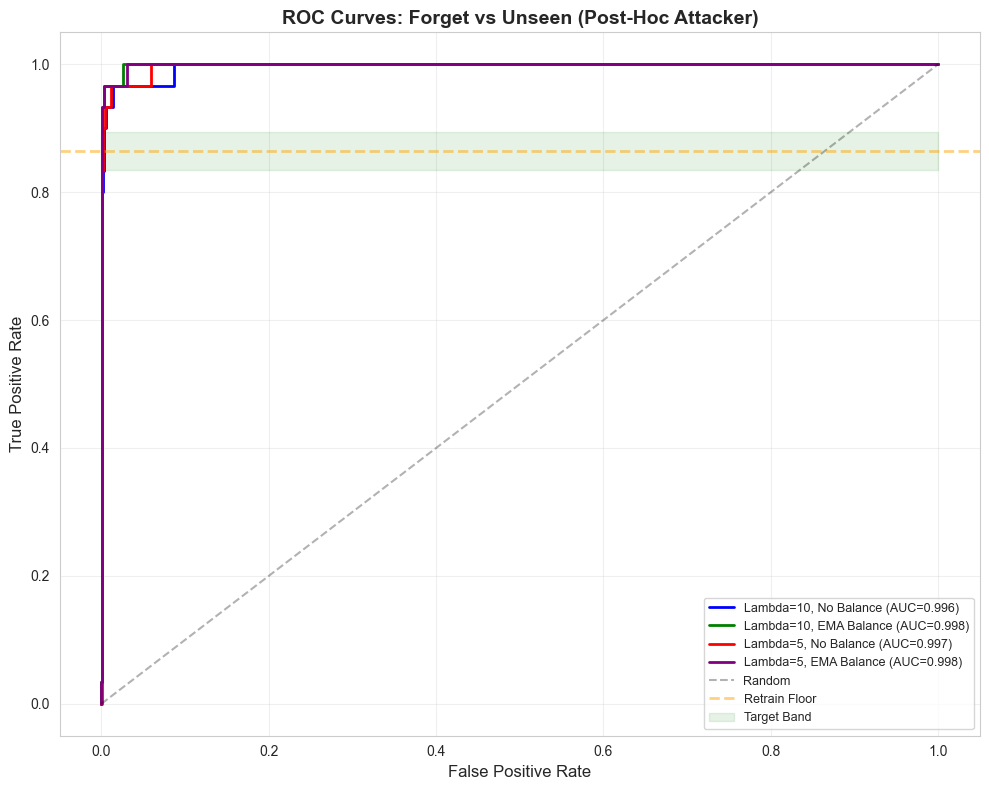

Saved: outputs/p2/sweep_roc_f_vs_u.png


In [8]:
# ROC curves - F vs U
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

colors = ['blue', 'green', 'red', 'purple']
for i, (result, color) in enumerate(zip(results, colors)):
    ax.plot(result['fpr_f_vs_u'], result['tpr_f_vs_u'], 
            color=color, linewidth=2, 
            label=f"{result['config']} (AUC={result['auc_f_vs_u']:.3f})")

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
ax.axhline(y=0.864, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Retrain Floor')
ax.fill_between([0, 1], 0.834, 0.894, alpha=0.1, color='green', label='Target Band')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Forget vs Unseen (Post-Hoc Attacker)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/sweep_roc_f_vs_u.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/p2/sweep_roc_f_vs_u.png")

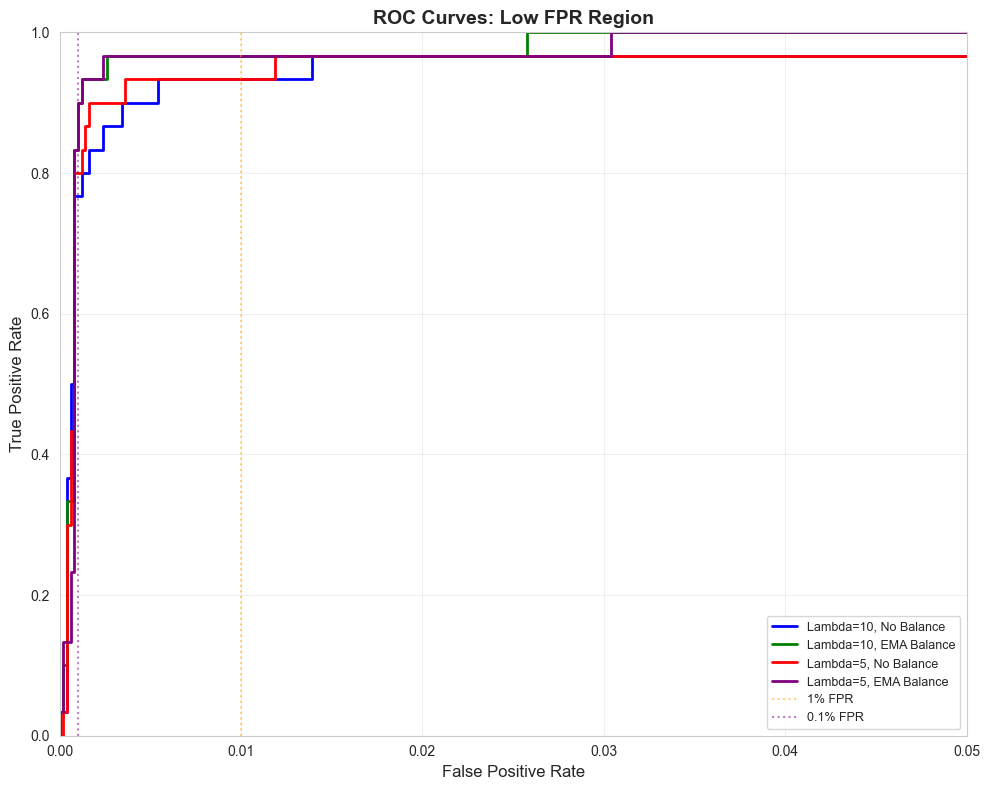

Saved: outputs/p2/sweep_roc_zoomed.png


In [9]:
# Zoomed ROC curves - Low FPR region
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for i, (result, color) in enumerate(zip(results, colors)):
    ax.plot(result['fpr_f_vs_u'], result['tpr_f_vs_u'], 
            color=color, linewidth=2, 
            label=f"{result['config']}")

ax.axvline(x=0.01, color='orange', linestyle=':', alpha=0.5, label='1% FPR')
ax.axvline(x=0.001, color='purple', linestyle=':', alpha=0.5, label='0.1% FPR')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Low FPR Region', fontsize=14, fontweight='bold')
ax.set_xlim([0, 0.05])
ax.set_ylim([0, 1.0])
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/p2/sweep_roc_zoomed.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/p2/sweep_roc_zoomed.png")

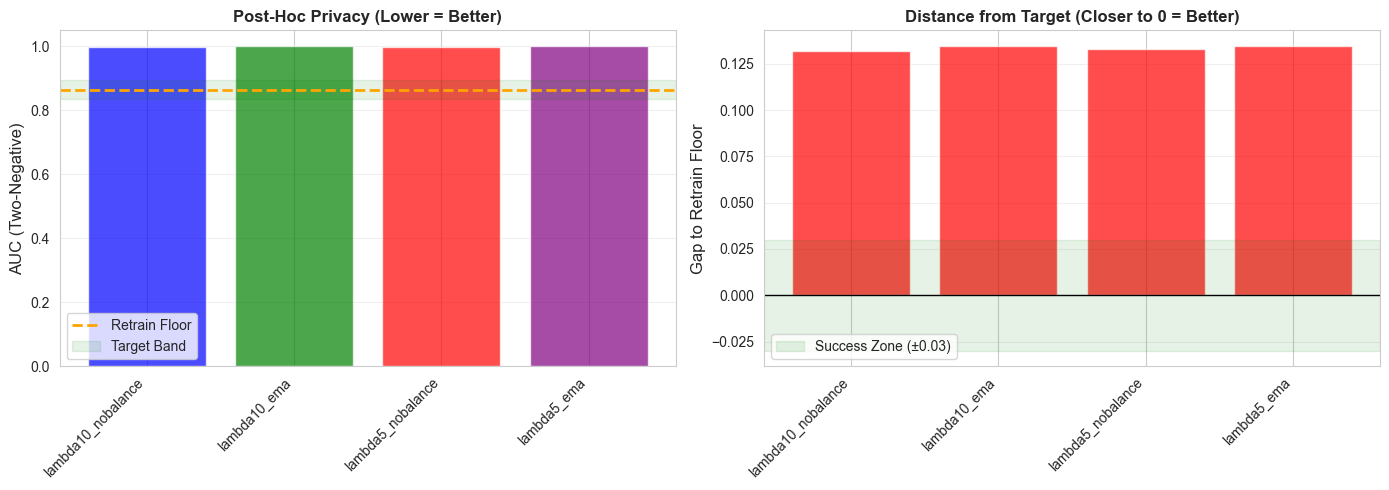

Saved: outputs/p2/sweep_comparison.png


In [10]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUC comparison
configs_short = [r['short_name'] for r in results]
aucs = [r['auc_two_negative'] for r in results]

axes[0].bar(range(len(aucs)), aucs, color=colors, alpha=0.7)
axes[0].axhline(y=0.864, color='orange', linestyle='--', linewidth=2, label='Retrain Floor')
axes[0].axhspan(0.834, 0.894, alpha=0.1, color='green', label='Target Band')
axes[0].set_ylabel('AUC (Two-Negative)', fontsize=12)
axes[0].set_title('Post-Hoc Privacy (Lower = Better)', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(len(configs_short)))
axes[0].set_xticklabels(configs_short, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Gap to floor
gaps = [r['gap_to_floor'] for r in results]
bar_colors = ['green' if abs(g) < 0.05 else 'orange' if abs(g) < 0.1 else 'red' for g in gaps]

axes[1].bar(range(len(gaps)), gaps, color=bar_colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].axhspan(-0.03, 0.03, alpha=0.1, color='green', label='Success Zone (±0.03)')
axes[1].set_ylabel('Gap to Retrain Floor', fontsize=12)
axes[1].set_title('Distance from Target (Closer to 0 = Better)', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(len(configs_short)))
axes[1].set_xticklabels(configs_short, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('outputs/p2/sweep_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: outputs/p2/sweep_comparison.png")

## 7. Save Results

In [ ]:
# Save individual results
for result in results:
    # Remove numpy arrays for JSON serialization
    result_json = {k: v for k, v in result.items() if not isinstance(v, np.ndarray)}
    
    output_path = Path(f"outputs/p2/{result['short_name']}_results.json")
    with open(output_path, 'w') as f:
        json.dump(result_json, f, indent=2)
    print(f"Saved: {output_path}")

# Save summary
summary = {
    'evaluation_date': '2025-11-08',
    'description': 'Multi-Critic Sweep with Gradient Fixes',
    'configurations': len(results),
    'benchmarks': {
        'baseline': 0.951,
        'multicritic_old_lambda1': 0.995,
        'retrain_floor': 0.864,
        'target_lower': 0.834,
        'target_upper': 0.894
    },
    'results': [{k: v for k, v in r.items() if not isinstance(v, np.ndarray)} for r in results],
    'best_config': min(results, key=lambda x: abs(x['gap_to_floor']))['config'],
    'best_auc': min(results, key=lambda x: abs(x['gap_to_floor']))['auc_two_negative']
}

summary_path = Path('outputs/p2/sweep_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\nSummary saved: {summary_path}")
print("\n=== EVALUATION COMPLETE ===")
print(f"Best config: {summary['best_config']}")
print(f"Best AUC: {summary['best_auc']:.4f}")
print(f"Gap to floor: {min(results, key=lambda x: abs(x['gap_to_floor']))['gap_to_floor']:+.3f}")